# A Variational Convolutional Autoencoder for unsupervised features extraction of ceramic profiles.  A case study from central Italy.

###  Importing libreries

In [1]:
# Pytorch
try:
    import torch
    from torchvision import transforms
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader
    from torchvision.utils import make_grid

    from Pots_nn_train import potds_torch, TrainingVAE, TestingVAE
except: 
    print("For full functionality it is necessary to install Pytorch: https://pytorch.org/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.preprocessing import MinMaxScaler

# Utils
from utils_and_plotting import LoadPots, PlotRecostruction, PlottingEmbeddings, KdePlot, WSDist


#### Set a random seed for reproducibility

In [2]:
# Set a random seed for reproducibility
def my_seed(seed):

    print("Selected seed: ",seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

In [3]:
my_seed(396)

Selected seed:  396


#### Set GPU as primary device for computation

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Selected device: {device}")

Selected device: cuda


## Loading data

In [5]:
pots = LoadPots("Latium_Etruria_pots.npz")
archeo_info = pd.read_csv("Etruria_Latium_ds.csv")

In [6]:
archeo_info

,ids,context_name,context_typology,chronology,funerary_function,context_id,Morphology,Functional_class,Region
0,ACQRSS_0001,Acquarossa,Settlement,EIA2,NaN,363,Open shape,Class 1,Etruria
1,ALTR_CNL_0003,Alatri - Canale,Settlement,FBA,NaN,386,Open shape,Class 1,Latium
2,ANGN_SNT_CECL_0001,Anagni - Santa Cecilia,Cultual,OP,NaN,528,Closed shape,Class 4,Latium
3,ANGN_SNT_CECL_0002,Anagni - Santa Cecilia,Cultual,OP,NaN,528,Closed shape,Class 4,Latium
4,ANGN_SNT_CECL_0003,Anagni - Santa Cecilia,Cultual,OP,NaN,528,Closed shape,Class 4,Latium
...,...,...,...,...,...,...,...,...,...
4987,VLL_PZZ_0003,Valle Pozzo,Funerary,EIA1,Grave good,145,Closed shape,Class 4,Latium
4988,VLL_PZZ_0004,Valle Pozzo,Funerary,EIA1,Grave good,145,Closed shape,Class 4,Latium
4989,VLL_PZZ_0005,Valle Pozzo,Funerary,EIA1,Grave good,145,Closed shape,Class 4,Latium
4990,VLL_PZZ_0006,Valle Pozzo,Funerary,FBA,Grave good,145,Open shape,Class 2,Latium


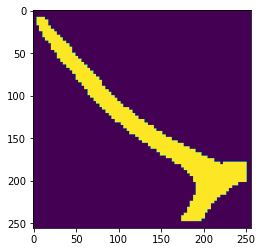

In [7]:
plt.imshow(pots[0])

### Define Hyperparameters

In [8]:
BATCH_SIZE = 128
EPOCHS = 25
LEARNING_RATE = 0.001
LATENT_DIMS = 10

### Prepare data for Autoencoder

#### Train & Test split

In [9]:
trn, tst = train_test_split(pots, test_size=0.20)
print("Train size:  "+ str(len(trn)))
print("Test size:  "+ str(len(tst)))

Train size:  3993
Test size:  999


#### Setting up Dataset transformation

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [11]:
potds_pytorch_trn = potds_torch(trn, transform=transform)
potds_pytorch_tst = potds_torch(tst, transform=transform)
potds_pytorch = potds_torch(pots, transform=transform)

In [12]:
data_loader_train = DataLoader(dataset = potds_pytorch_trn, batch_size=BATCH_SIZE, shuffle=True)
data_loader_test = DataLoader(dataset = potds_pytorch_tst, batch_size=64, shuffle=True)
data_loader_eval = DataLoader(dataset = potds_pytorch, batch_size=64, shuffle=False)

##### Checking Batch shape and length

In [13]:
x= next(iter(data_loader_train))
x.shape

torch.Size([128, 1, 256, 256])

#### View a Batch

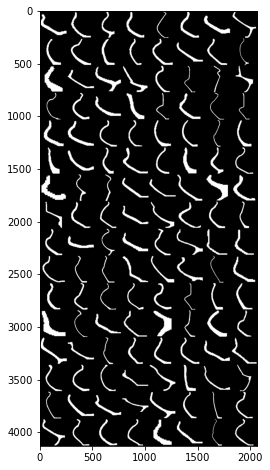

In [14]:
im = make_grid(x, nrow=8)

fig = plt.figure(figsize=(24,8))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))
fig.savefig(f"batch.jpg", dpi = 300)

### Define Autoencoder structure and parameters

In [15]:
from Pots_nn_train import VariationalAutoencoder

In [16]:
### Instancing the model
vae = VariationalAutoencoder(latent_dims=LATENT_DIMS)
### Define loss function and optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
# Define Recostruction Loss
loss_fn = F.mse_loss

In [17]:
### View the number of tunable parameter
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters: " + str(count_parameters(vae)))

Total number of parameters: 2306293


In [18]:
vae.to(device)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): ReLU(inplace=True)
    (15): Linear(in_features=8192, o

## Training time!

In [19]:
outputs_train, losses_train = TrainingVAE(vae, EPOCHS, data_loader_train,  device, loss_fn, optimizer)

Epoch [1/25] Batch 1/32, Loss : 21162.4355
Epoch [1/25] Batch 2/32, Loss : 20891.3652
Epoch [1/25] Batch 3/32, Loss : 20551.8770
Epoch [1/25] Batch 4/32, Loss : 20300.7383
Epoch [1/25] Batch 5/32, Loss : 20049.1934
Epoch [1/25] Batch 6/32, Loss : 19830.2246
Epoch [1/25] Batch 7/32, Loss : 19627.7793
Epoch [1/25] Batch 8/32, Loss : 19461.5020
Epoch [1/25] Batch 9/32, Loss : 19223.2520
Epoch [1/25] Batch 10/32, Loss : 18976.8047
Epoch [1/25] Batch 11/32, Loss : 18826.6719
Epoch [1/25] Batch 12/32, Loss : 18666.2148
Epoch [1/25] Batch 13/32, Loss : 18458.7109
Epoch [1/25] Batch 14/32, Loss : 18286.3516
Epoch [1/25] Batch 15/32, Loss : 18185.0137
Epoch [1/25] Batch 16/32, Loss : 17979.9609
Epoch [1/25] Batch 17/32, Loss : 17862.2734
Epoch [1/25] Batch 18/32, Loss : 17625.4336
Epoch [1/25] Batch 19/32, Loss : 17530.0547
Epoch [1/25] Batch 20/32, Loss : 17368.8730
Epoch [1/25] Batch 21/32, Loss : 17145.5840
Epoch [1/25] Batch 22/32, Loss : 17074.9277
Epoch [1/25] Batch 23/32, Loss : 16859.86

### Plot Training recostruction

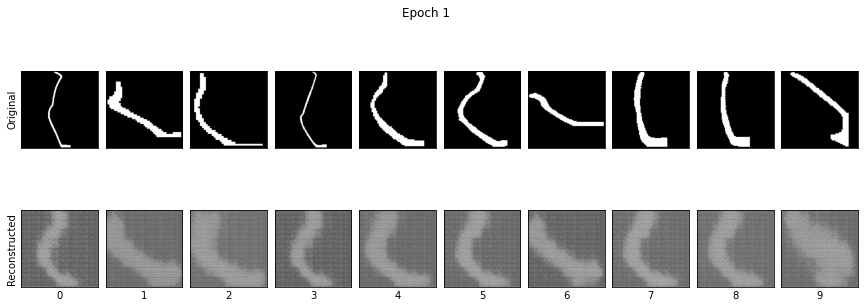

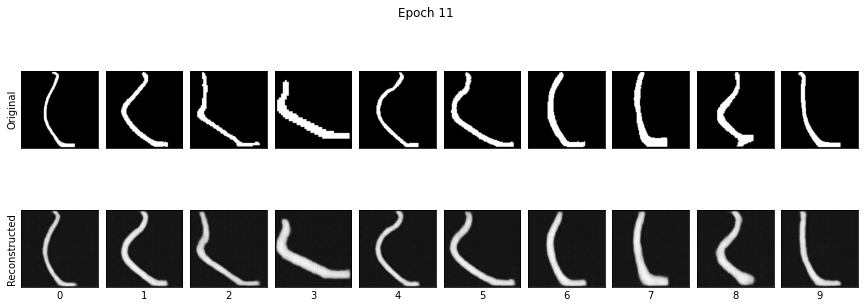

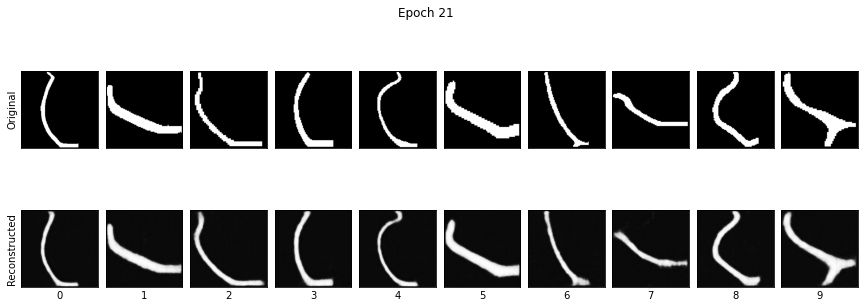

In [20]:
PlotRecostruction(outputs_train, start = 0, stop = EPOCHS, plt_range = 10, plt_number = 10, QuickCleaning=False,SaveFig=True)

## Testing 

In [21]:
outputs_tst, losses_tst = TestingVAE(vae, EPOCHS, data_loader_test,  device, loss_fn)

Mean test loss: 1365.35


#### Plotting Test dataset

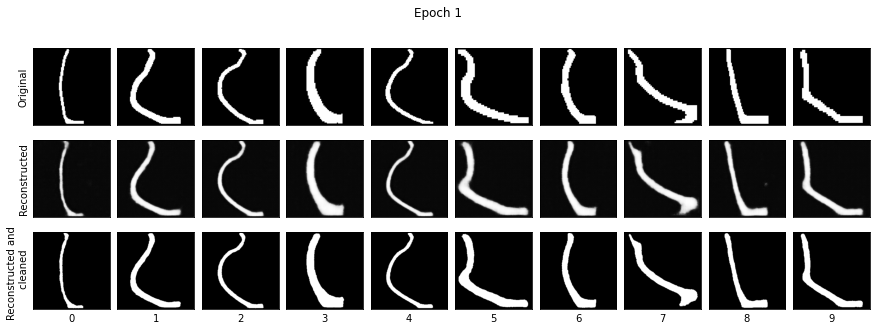

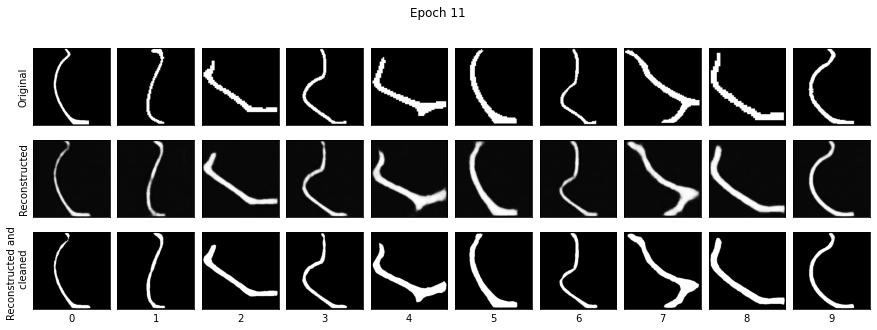

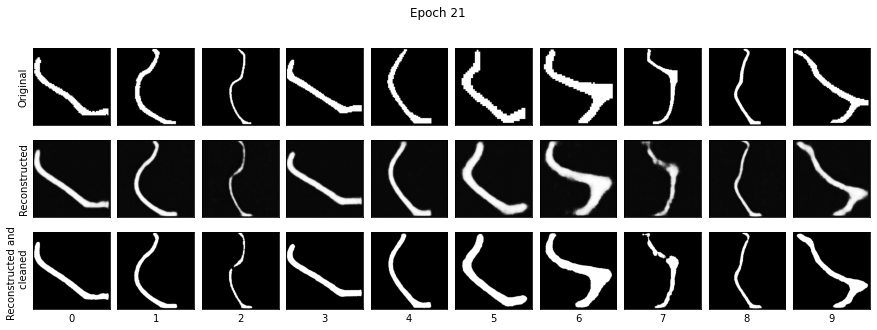

In [22]:
PlotRecostruction(outputs_tst, start = 0, stop = EPOCHS, plt_range = 10, plt_number = 10, QuickCleaning=True, Training = True, SaveFig=True)

### Plotting Train and Test Loss

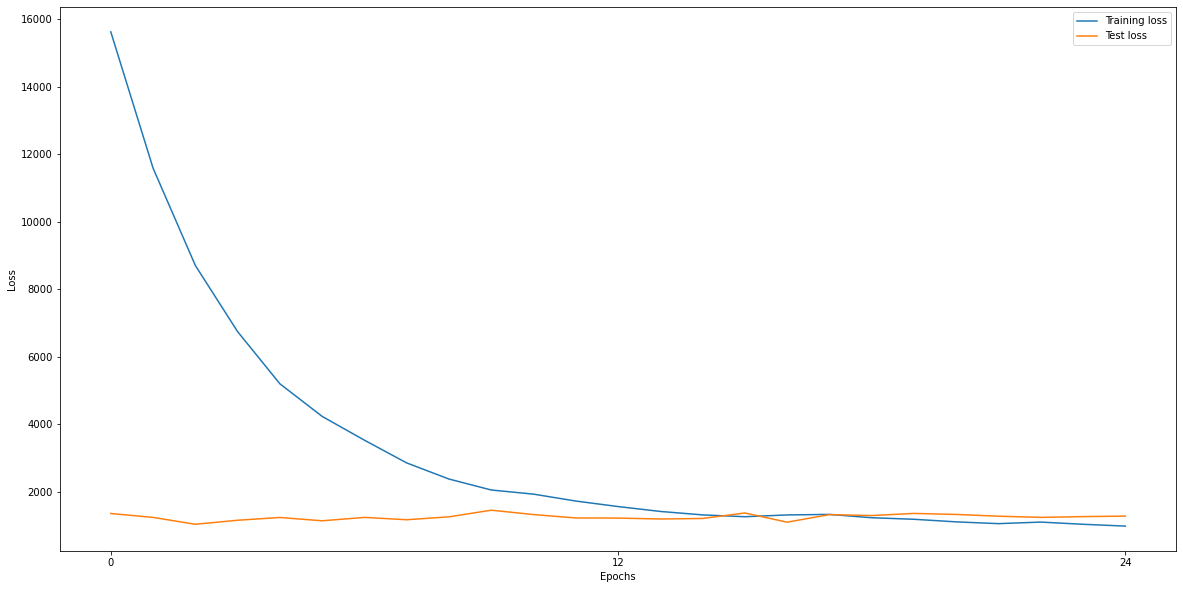

In [23]:
fig = plt.figure(figsize=(20,10))
plt.plot((np.array(losses_train))[:,1], label = "Training loss")
plt.xticks(np.arange(0, EPOCHS+1, EPOCHS//2))
plt.plot((np.array(losses_tst))[:,1], label = "Test loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
fig.savefig(f"Train_test_loss.jpg", dpi = 300)


# Accessing Latent Dimension

In [24]:
encoded_samples = []
for b, img in enumerate(data_loader_eval):
    img = img.to(device)
    vae.to(device)
    vae.eval()
    with torch.no_grad():
        encoded_img, _, _, _  = vae(img.float())
        encoded_img = encoded_img.cpu().numpy()
    encoded_samples.extend(encoded_img)
    encoded_dim = np.array(encoded_samples)

In [25]:
# Check encoded spaces dimension
encoded_dim.shape

(4992, 10)

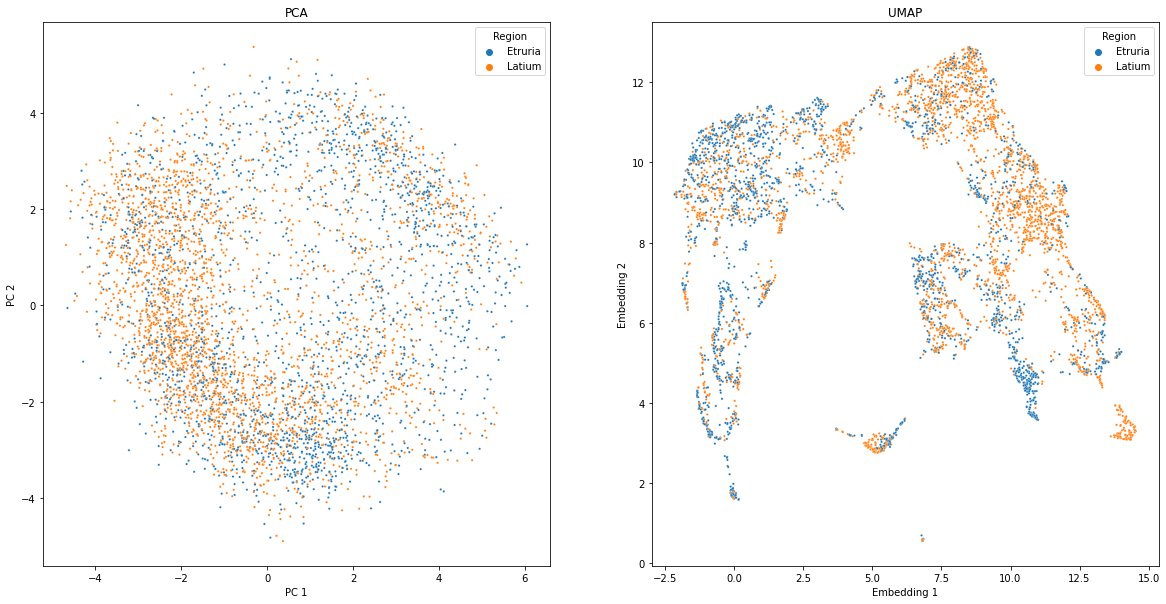

In [26]:
PlottingEmbeddings(encoded_dim, archeo_info, labels = "Region", SaveFig=True)

### Normalize encoded dimension

In [27]:
load_excel = True

In [28]:
if load_excel:
    encoded_dim_df = pd.read_excel("encoded_dim.xlsx")
    encoded_dim = MinMaxScaler().fit_transform(encoded_dim_df)
    encoded_df_norm = pd.DataFrame(encoded_dim, archeo_info.index)
else:
    # Normalize encoded data
    encoded_dim_df = pd.DataFrame(encoded_dim, archeo_info.index)
    encoded_dim = MinMaxScaler().fit_transform(encoded_dim)
    encoded_df_norm = pd.DataFrame(encoded_dim, archeo_info.index)


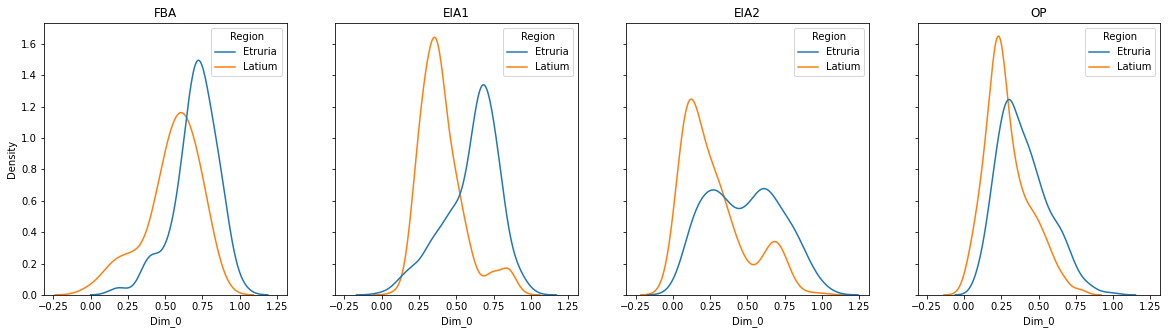

In [29]:
KdePlot(encoded_df_norm, archeo_info, subsampling = True, SaveFig=True)

,Run,Epochs,Wasserstein
0,0,FBA,0.090624
1,0,EIA1,0.211147
2,0,EIA2,0.174627
3,0,OP,0.082862
4,1,FBA,0.140983
...,...,...,...
195,48,OP,0.095267
196,49,FBA,0.155343
197,49,EIA1,0.171312
198,49,EIA2,0.188936


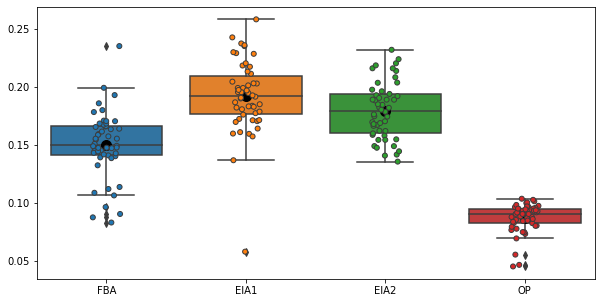

In [31]:
WSDist(encoded_df_norm, archeo_info, 50, SaveFig = True, PlotType = "boxplot", show_points= True)

### Counter-test

In [32]:
from utils_and_plotting import NCA
import seaborn as sns
from scipy.stats import wasserstein_distance
from scipy.spatial import distance

In [33]:
chronology = ["FBA", "EIA1", "EIA2", "OP"]
regions = ["Latium", "Etruria"]

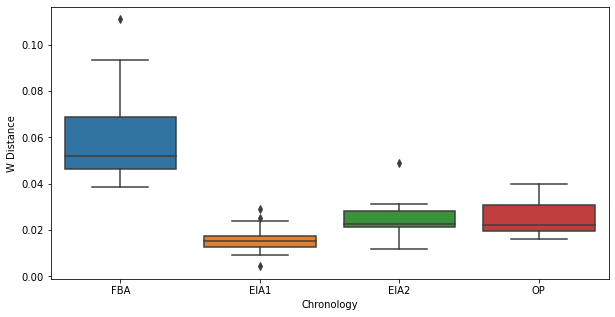

In [34]:
wd = []

my_list = []
for i, chrono in enumerate(chronology):
    with pd.option_context('mode.chained_assignment',None):
        info_selected_chrono = archeo_info[(archeo_info.chronology == chrono)]


    

        for n in range(0, 20):

            
            info_selected_chrono["random_label"] = np.random.randint(0, 2, size=len(info_selected_chrono))

            nca_test = NCA(encoded_df_norm.loc[info_selected_chrono.index], info_selected_chrono["random_label"], n_components=1)

            info_selected_chrono["nca"] = MinMaxScaler().fit_transform(nca_test)

            info_selected_chrono_0 = info_selected_chrono.loc[info_selected_chrono["random_label"]== 0]
            info_selected_chrono_1 = info_selected_chrono.loc[info_selected_chrono["random_label"]== 1]

            wd_chrono = wasserstein_distance(info_selected_chrono_0["nca"], info_selected_chrono_1["nca"])

            my_list.append((chrono, wd_chrono, len(info_selected_chrono)))



        random_label_s_df= pd.DataFrame(my_list, columns=["Chronology", "W Distance", "samples"])
fig, ax = plt.subplots(1, 1, figsize = (10,5))
sns.boxplot(data = random_label_s_df, y = "W Distance",x = "Chronology")
fig.savefig(f"WS_random_plot.jpg", dpi = 300)

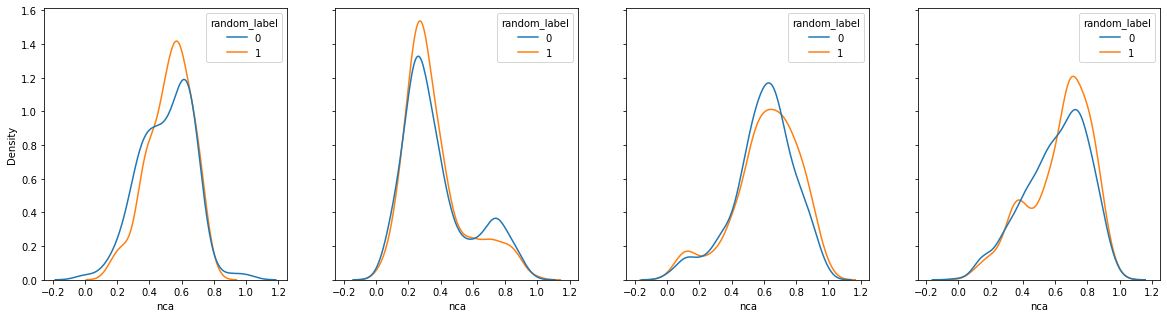

In [35]:
wd = []
with pd.option_context('mode.chained_assignment',None):
    fig, ax = plt.subplots(1, 4, sharex="row", sharey="row", figsize = (20,5))

    for i, chrono in enumerate(chronology):
        info_selected_chrono = archeo_info[(archeo_info.chronology == chrono)]

        info_selected_chrono["random_label"] = np.random.randint(0, 2, size=len(info_selected_chrono))

        nca_test = NCA(encoded_df_norm.loc[info_selected_chrono.index], info_selected_chrono["random_label"], n_components=1)

        info_selected_chrono["nca"] = MinMaxScaler().fit_transform(nca_test)

        info_selected_chrono_0 = info_selected_chrono.loc[info_selected_chrono["random_label"]== 0]
        info_selected_chrono_1 = info_selected_chrono.loc[info_selected_chrono["random_label"]== 1]

        wd_region = wasserstein_distance(info_selected_chrono_0["nca"], info_selected_chrono_1["nca"])

        wd.append((chrono, wd_region, len(info_selected_chrono)))

        sns.kdeplot(data = info_selected_chrono,x = "nca", hue = "random_label", ax = ax[i])

fig.savefig(f"KDE_random.jpg", dpi = 300)